In [42]:
import debugpy
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
import gzip
import numpy as np
import cell2location

<center><h3><B> Loading VisiumHD

In [59]:
def calcQCmat(andata):
    andata.var_names_make_unique()
    andata.var["mt"] = andata.var_names.str.startswith("mt-")
    andata.var["ribo"] = andata.var_names.str.startswith(("RPS", "RPL"))
    andata.var["hb"] = andata.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(andata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
    return andata
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Mouse_Brain_square_example/square_016um"
andata016_ = sc.read_visium(path=path_016)
andata016 = calcQCmat(andata016_)
andata016 = andata016[:,andata016.var.n_cells_by_counts > 50]
andata016.raw = andata016.copy()
sc.pp.normalize_total(andata016)
sc.pp.log1p(andata016)
log1p_data = andata016.X.todense()
sc.pp.highly_variable_genes(andata016)
sc.pp.scale(andata016)
andata016.obsm['spatial'] = np.array(andata016.obsm['spatial'], dtype=np.float64)
sc.pp.pca(andata016, n_comps=10)
sc.pp.neighbors(andata016)
sc.tl.leiden(andata016, key_added="clusters" ,resolution=0.7 , directed=False, n_iterations=2)

/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/scanpy/readwrite.py:413: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(files['tissue_positions_file'], header=None)


<center><h3><B> Loading scRNA data

In [2]:
# adata_ref = sc.read(
#     f'38795736-71ed-4b5d-b7a1-91a9b60d52a2.h5ad',
#     backup_url='https://datasets.cellxgene.cziscience.com/38795736-71ed-4b5d-b7a1-91a9b60d52a2.h5ad'
# )
adata_ref = sc.read('38795736-71ed-4b5d-b7a1-91a9b60d52a2.h5ad')
adata_ref.X = adata_ref.raw.X

/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


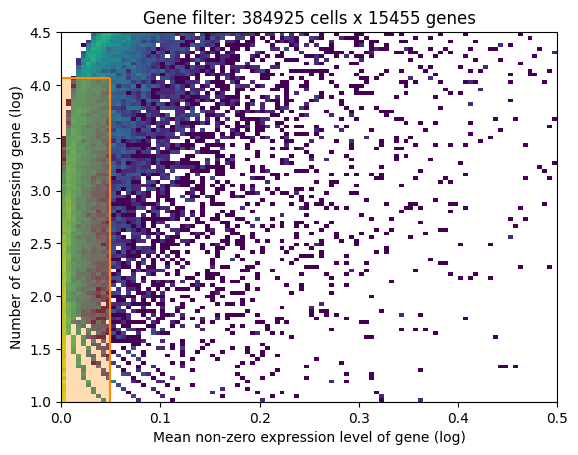

KeyboardInterrupt: 

In [4]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [ ]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Batch_ID',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['assay']
                       )

In [ ]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=250, use_gpu=True)

In [7]:
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'use_gpu': True}
)

Sampling global variables, sample: 100%|██████████████████████████████████████████████| 999/999 [00:13<00:00, 74.76it/s]


In [3]:
# The model and output h5ad can be loaded later like this:
results_folder = './out/cell2loc/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'


adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

In [13]:
adata_ref.obs['cell_type']

AAACCCAAGGGTGAAA-1_SRR14252354            neuron
AAACCCACAGCACACC-1_SRR14252354            neuron
AAACCCATCCCGAAAT-1_SRR14252354            neuron
AAACGAAAGACCAGCA-1_SRR14252354            neuron
AAACGAAAGGTCCAGA-1_SRR14252354            neuron
                                       ...      
GTCACCCCCGAA_SRR7535555                   neuron
TTGTAGTTGAGT_SRR7535555           ependymal cell
TTTTCCACCCCT_SRR7535555                   neuron
GGTGAGGCGGTG_SRR7535555                   neuron
GATTAACGGCGG_SRR7535555                   neuron
Name: cell_type, Length: 384925, dtype: category
Categories (13, object): ['fibroblast', 'ependymal cell', 'endothelial cell', 'astrocyte', ..., 'oligodendrocyte precursor cell', 'mural cell', 'pituitary gland cell', 'hypendymal cell']

In [17]:
inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()

In [18]:
inf_aver.columns = adata_ref.uns['mod']['factor_names']

In [19]:
inf_aver.iloc[0:5, 0:5]

,fibroblast,ependymal cell,endothelial cell,astrocyte,oligodendrocyte
ENSMUSG00000051951,0.001433,0.000771,0.000077,0.000186,0.005343
ENSMUSG00000103377,0.000602,0.000649,0.000062,0.000029,0.001967
ENSMUSG00000104017,0.000849,0.001388,0.000075,0.000019,0.001560
ENSMUSG00000089699,0.000395,0.000240,0.000053,0.000016,0.000017
ENSMUSG00000103161,0.000335,0.001076,0.000082,0.000029,0.000790


In [60]:
andata016.var_names

Index(['Xkr4', 'Sox17', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Oprk1',
       'Npbwr1', 'Rb1cc1', 'St18',
       ...
       'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5',
       'mt-Nd6', 'mt-Cytb', 'Vamp7'],
      dtype='object', length=13964)

In [61]:
andata016.var.set_index('gene_ids', drop=True, inplace=True)
andata016.var

,feature_types,genome,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
gene_ids,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,Gene Expression,mm10,False,False,False,4837,0.053176,0.051810,95.110042,5260.0,8.568076,False,0.032296,0.075234,-1.202811,0.023201,0.117684
ENSMUSG00000025902,Gene Expression,mm10,False,False,False,709,0.007885,0.007854,99.283237,780.0,6.660575,False,0.008487,0.649225,1.555923,0.005139,0.067161
ENSMUSG00000025903,Gene Expression,mm10,False,False,False,2083,0.021624,0.021394,97.894194,2139.0,7.668561,False,0.015538,0.221813,-0.498320,0.010742,0.084022
ENSMUSG00000033813,Gene Expression,mm10,False,False,False,11157,0.127268,0.119797,88.720847,12589.0,9.440659,False,0.085888,0.231577,-0.451390,0.060431,0.196228
ENSMUSG00000002459,Gene Expression,mm10,False,False,False,4643,0.049658,0.048464,95.306166,4912.0,8.499640,False,0.040883,0.425136,0.478900,0.027108,0.140343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064363,Gene Expression,mm10,True,False,False,74014,1.752489,1.012506,25.175652,173351.0,12.063080,False,1.023667,1.000293,0.285638,0.800459,0.641889
ENSMUSG00000064367,Gene Expression,mm10,True,False,False,75405,1.894366,1.062766,23.769423,187385.0,12.140926,False,1.045383,0.918470,-0.907876,0.830585,0.637000
ENSMUSG00000064368,Gene Expression,mm10,True,False,False,20290,0.239190,0.214458,79.487853,23660.0,10.071584,True,0.234762,0.718311,1.495231,0.151443,0.348762


In [62]:
andata016.raw.X

<98917x13964 sparse matrix of type '<class 'numpy.float32'>'
	with 68181764 stored elements in Compressed Sparse Row format>

In [66]:
len(np.intersect1d(andata016.var_names, inf_aver.index))

12030

In [63]:
andata016.X = andata016.raw.X

In [64]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(andata016.var_names, inf_aver.index)
adata_vis = andata016[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [67]:
adata_vis

AnnData object with n_obs × n_vars = 98917 × 12030
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'clusters'
    var: 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [39]:
adata_vis.raw.X

<98917x19059 sparse matrix of type '<class 'numpy.float32'>'
	with 68259814 stored elements in Compressed Sparse Row format>

In [68]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key=None)

In [69]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=10,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 98917 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12030 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [71]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.3/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.3/lib/p ...
  rank_zero_warn(
/usr/local/apps/cell2location/conda/envs/0.1

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.43 GiB (GPU 0; 15.89 GiB total capacity; 13.38 GiB already allocated; 2.20 GiB free; 13.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
# The model and output h5ad can be loaded later like this:
results_folder = './out/cell2loc/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'


adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./out/cell2loc//reference_signatures/model.pt already downloaded                                     


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2location/conda/envs/0.1.3/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/apps/cell2location/conda/envs/0.1.3/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usr/local/apps/cell2locat

Epoch 1/52:   2%|▊                                         | 1/52 [00:00<00:20,  2.47it/s, v_num=1, elbo_train=3.93e+9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/52:   2%|▊                                         | 1/52 [00:00<00:21,  2.43it/s, v_num=1, elbo_train=3.93e+9]


In [3]:
adata_ref

AnnData object with n_obs × n_vars = 384925 × 15455
    obs: 'SRA_ID', 'Sample_ID', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'Dataset', 'Batch_ID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'C7_named', 'C25_named', 'C66_named', 'C185_named', 'C286_named', 'C465_named', 'Author_Class_Curated', 'Author_CellType', 'Region_summarized', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_condition', 'citation', 'mo

In [5]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_obsm = ["means", "stds", "q05", "q95"],
)

TypeError: export_posterior() got an unexpected keyword argument 'add_to_obsm'

In [3]:
mod.plot_QC()

RuntimeError: self.samples is missing, please run self.export_posterior() first